## Exponential Moving Average
t_i = alpha * t_{i-1} + (1 - alpha) * s_i, with a value of alpha = 0.99

In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.model import mean_teacher

Using TensorFlow backend.


In [3]:
configs = {
    'input_shape': (480,640,3),
    'num_of_classes': 10
}

In [4]:
student_model, teacher_model = mean_teacher(configs)

Instructions for updating:
Colocations handled automatically by placer.


/home/dh/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/dh/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
def ema(student_model, teacher_model, alpha = 0.99):
    '''
    Calculates the exponential moving average of the student model weights and updates the teacher model weights\
    
    formula:
    t_i = alpha * t_{i-1} + (1 - alpha) * s_i, with default alpha = 0.99
    t_i = weights of teacher model in current epoch
    s_i = weights of student model in current epoch
    
    '''
    
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()
    
    assert len(student_weights) == len(teacher_weights), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format(len(student_weights), len(teacher_weights))
    
    new_layers = []
    for i, layers in enumerate(student_weights):
        new_layer = alpha*(teacher_weights[i]) + (1-alpha)*layers
        new_layer.trainable = False
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    

## Loss function
### model architecture

![test](pictures/student_teacher_model_arch.png)

useful links:
- https://keras.io/layers/about-keras-layers/
- https://keras.io/getting-started/functional-api-guide/
- https://github.com/keras-team/keras/blob/master/keras/losses.py
- https://keras.io/getting-started/functional-api-guide/
- https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618
- https://stackoverflow.com/questions/38972380/keras-how-to-use-fit-generator-with-multiple-outputs-of-different-type

In [5]:
from keras.optimizers import Adam
from keras.models import Model
import keras.backend as K

In [ ]:
def categorical_crossentropy(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred)

In [ ]:
def weighted_sum_loss(squared_difference_layer):

    def categorical_crossentropy_custom(y_true, y_pred):
        ratio = 0.5
        return ratio * K.categorical_crossentropy(y_true, y_pred) + (1 - ratio)*squared_difference_layer
    
    return categorical_crossentropy_custom

In [ ]:
x_src = Input()
x_tgt = Input()
x_src_student = student_model(x_src)
x_tgt_student = student_model(x_tgt)
x_tgt_teacher = teacher_model(x_tgt)
# outputs = K.square(student_model.output - teacher_model.output)
sq_diff = K.sum(K.square( x_tgt_student - x_tgt_teacher ))

def custom_loss(y_true, y_pred):
    ratio = 0.5
    return ratio * K.categorical_crossentropy(y_true, y_pred) + (1 - ratio)*sq_diff


Model([x_src, x_tgt], x_src_student)

# Data Generator

useful links:
- https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a

In [7]:
def get_distribution(data_path, label, color):
    walker = os.walk(data_path)
    next(walker) # skip the first row
    class_freq = dict()
    for r,d,f in walker:
        class_freq[r.split('/')[-1]] = len(f)
    class_freq_df = pd.DataFrame.from_dict(class_freq, orient = 'index', columns = ['count'])
    class_freq_df.reset_index(inplace = True)
    class_freq_df.columns = [label, 'count']
    class_freq_df.sort_values('count', axis = 0, ascending=False, inplace=True)
    
    sns.catplot(x = 'count', y = label, kind = 'bar', data=class_freq_df, color = color)

In [8]:
color_1 = sns.xkcd_rgb['denim blue']
color_2 = sns.xkcd_rgb['dusty purple']

In [6]:
syn_path = os.path.join(os.getcwd(), 'data', 'synthetic')
real_path = os.path.join(os.getcwd(), 'data', 'real')

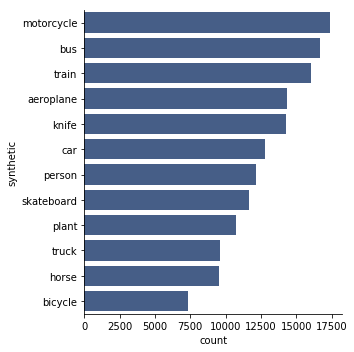

In [10]:
get_distribution(syn_path, 'synthetic', color_1)

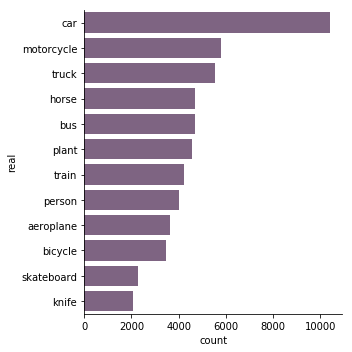

In [11]:
get_distribution(real_path, 'real', color_2)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [35]:
sup_gen = ImageDataGenerator()
unsup_gen = ImageDataGenerator()

sup_data_gen = sup_gen.flow_from_directory(syn_path)

Found 152397 images belonging to 12 classes.


In [23]:
configs = {'batch_size': 32,
          'target_size': (224,224)}

In [27]:
def mean_teacher_data_gen(sup_gen, unsup_gen, batch_size, target_size):
    '''
    
    '''
    
    syn_path = os.path.join(os.getcwd(), 'data', 'synthetic')
    real_path = os.path.join(os.getcwd(), 'data', 'real')

    sup_data_gen = sup_gen.flow_from_directory(real_path,
                                                    class_mode='categorical')

    unsup_data_gen = unsup_gen.flow_from_directory(syn_path,
                                                        class_mode='categorical')
    
    while True:
    
        syn_img, syn_labels = sup_data_gen.next()
        real_img, _ = unsup_data_gen.next()

        yield [syn_img, real_img] , syn_labels

In [28]:
mean_teacher_generator = mean_teacher_data_gen(sup_gen, unsup_gen, configs['batch_size'], configs['target_size'])

In [29]:
inputs, outputs = next(mean_teacher_generator)

Found 55388 images belonging to 12 classes.
Found 152397 images belonging to 12 classes.


In [30]:
syn_img, real_img = inputs

In [43]:
class_dict = dict[(v,k) for (k,v) in sup_data_gen.class_indices]

SyntaxError: invalid syntax (<ipython-input-43-683fb81e20aa>, line 1)

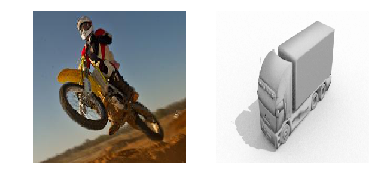

In [34]:
fig,ax = plt.subplots(1,2)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(syn_img[0].astype(np.uint8))
ax[1].imshow(real_img[0].astype(np.uint8))
plt.title(class)
plt.show()

In [ ]:
for i, syn_i in enumerate(syn_img):
    ax, fig = plt.subplot([2,1])
    